## Importing the required libraries

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import os
from keras import regularizers

## Link to dataset

https://tuenl.sharepoint.com/sites/gad_cbo/JPC/MC/ESA%20PDEng%20ST%20Project/Forms/AllItems.aspx?viewid=235c9f56%2Db4dc%2D418e%2D8800%2Dd0cde58fff30&id=%2Fsites%2Fgad%5Fcbo%2FJPC%2FMC%2FESA%20PDEng%20ST%20Project%2FModelsAndData%2FAudio%2FDevelopment%2Fdata%2Ftone%5Fcnn%5Fhappy%5Fangry%5Fdataset

In [2]:
from pathlib import Path
curr_path = os.getcwd()
crr_path = Path(curr_path)
parent_path = crr_path.parent
path = str(parent_path) +  '\\data\\tone_cnn_happy_angry_dataset\\'
mylist= os.listdir(path)

## Plotting the audio file's waveform and its spectrogram for one sample audio track

In [3]:
data, sampling_rate = librosa.load(path + '03-02-03-01-01-02-01.wav')

Populating the interactive namespace from numpy and matplotlib


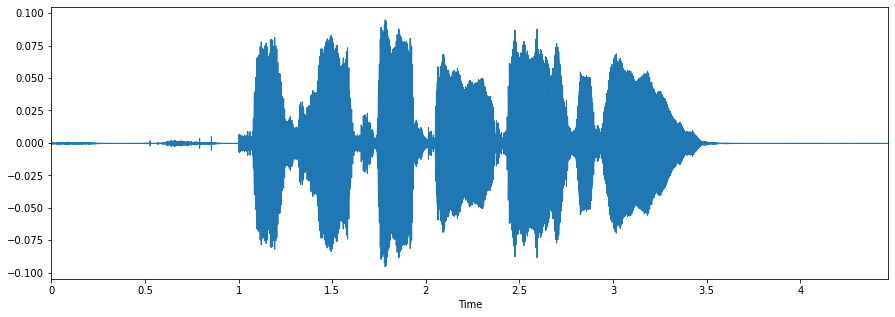

In [4]:
%pylab inline
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

<ipython-input-5-d1a44c7199b3>:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr,x = scipy.io.wavfile.read(path+'03-02-03-01-01-02-01.wav')
<ipython-input-5-d1a44c7199b3>:26: RuntimeWarning: divide by zero encountered in log
  X[i,:] = np.log(np.abs(z[:nfft//2]))


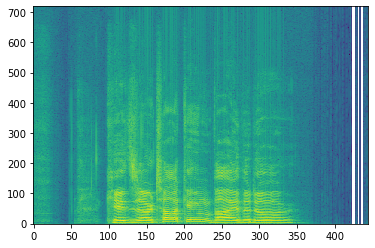

In [5]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys


sr,x = scipy.io.wavfile.read(path+'03-02-03-01-01-02-01.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

## Setting the labels

In [6]:
feeling_list=[]
for item in mylist:
    if item[6:-16]=='03':
        feeling_list.append('Happy')
    elif item[6:-16]=='05':
        feeling_list.append('Angry')

In [7]:
labels = pd.DataFrame(feeling_list)

In [8]:
labels[:10]

,0
0,Happy
1,Happy
2,Happy
3,Happy
4,Happy
5,Happy
6,Happy
7,Happy
8,Happy
9,Happy


## Getting the features of audio files using librosa

In [9]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
        X, sample_rate = librosa.load(path+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=13),
                        axis=0)
        feature = mfccs
        #[float(i) for i in feature]
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1        

In [10]:
df3 = pd.DataFrame(df['feature'].values.tolist())

In [11]:
newdf = pd.concat([df3,labels], axis=1)

In [12]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [13]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
19,-55.903008,-54.756767,-55.139877,-59.083748,-59.381008,-55.039658,-53.489647,-54.310509,-53.869026,-53.800377,...,-27.565929,-27.229801,-27.707989,-25.899975,-24.971737,-25.702152,-27.269041,-27.372200,-27.709175,Angry
0,-57.811569,-57.811569,-57.811569,-57.811569,-57.811569,-57.811569,-57.811569,-57.811569,-57.811569,-57.811569,...,-27.088243,-26.903568,-25.609509,-23.793528,-24.944103,-29.169176,-30.318075,-26.655012,-24.080944,Happy
32,-45.438675,-45.438675,-45.438675,-45.438675,-45.438675,-45.438675,-45.438675,-45.438675,-45.438675,-45.438675,...,-29.975843,-32.766464,-34.845787,-33.423199,-32.916061,-32.028511,-32.148949,-21.179567,-14.162803,Angry
18,-53.215141,-53.821835,-55.702251,-56.110741,-54.484108,-54.016575,-53.258480,-52.127930,-52.911907,-52.331638,...,-25.371704,-23.986441,-23.056210,-22.540562,-22.526701,-23.259460,-25.210693,-22.763496,-19.199444,Angry
30,-46.179008,-46.179008,-46.179008,-46.179008,-46.179008,-46.179008,-46.396156,-44.033684,-45.268570,-45.342522,...,-13.857107,-12.956606,-13.621500,-15.496888,-17.532106,-17.477491,-19.611433,-15.654792,-10.299941,Angry
20,-58.159763,-58.133118,-57.912991,-57.732590,-58.551922,-58.696270,-58.931820,-58.761360,-58.345924,-57.179695,...,-32.594246,-33.565231,-34.794029,-36.820827,-37.547710,-39.285606,-38.538078,-21.728119,-14.077530,Angry
24,-44.510063,-44.510063,-44.510063,-44.510063,-44.510063,-44.510063,-44.510063,-44.510063,-44.510063,-44.510063,...,-37.799252,-38.515030,-36.769436,-35.965473,-35.868397,-34.505363,-35.027534,-33.120918,-27.197109,Angry
16,-53.915813,-53.890678,-53.699604,-53.366581,-53.414326,-51.962624,-51.702873,-50.795010,-50.524319,-50.677872,...,-26.425497,-27.277546,-27.780582,-28.780750,-26.044004,-24.974621,-22.341837,-21.274040,-20.113626,Happy
15,-47.009068,-47.387703,-47.875713,-49.496597,-48.368076,-47.545490,-47.604385,-47.896545,-47.376652,-48.484165,...,-28.412235,-28.703968,-28.638834,-30.290831,-29.805490,-28.255247,-26.729494,-20.331326,-15.849621,Happy
31,-42.252037,-42.333694,-44.807594,-46.217442,-43.448059,-42.951027,-41.224636,-40.165993,-40.393204,-40.705563,...,-20.582745,-20.620125,-18.665709,-19.291042,-22.125511,-21.364594,-20.553825,-18.150845,-14.239759,Angry


In [14]:
rnewdf=rnewdf.fillna(0)

## Dividing the data into test and train

In [15]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [16]:
train[10:20]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
12,-47.351765,-47.351765,-47.351765,-47.351765,-47.351765,-47.351765,-47.351765,-47.393234,-47.331501,-47.213520,...,-34.778091,-34.759289,-35.435650,-34.468674,-33.842056,-33.283600,-33.502396,-17.016195,-9.720584,Happy
8,-53.716934,-53.972878,-53.181664,-53.558559,-54.397457,-51.155869,-47.766846,-48.338928,-49.246017,-48.674454,...,-36.598652,-35.003216,-37.495651,-39.526485,-39.820679,-41.155258,-42.694405,-28.852785,-21.370258,Happy
7,-54.618992,-54.074741,-56.352791,-59.550545,-58.432732,-55.242760,-54.547325,-56.185379,-57.388470,-57.412113,...,-31.968554,-30.679962,-31.553383,-27.987570,-25.827244,-24.439589,-25.158400,-21.805180,-16.859730,Happy
5,-47.490520,-49.036922,-50.286381,-50.849983,-51.633354,-49.025963,-48.484539,-47.893723,-48.466713,-49.182980,...,-25.367676,-26.423412,-28.633671,-28.652311,-28.508036,-26.839354,-27.473660,-23.825676,-20.764921,Happy
3,-57.011089,-56.533325,-55.997982,-56.788410,-59.220562,-49.699871,-44.694660,-45.418980,-46.613422,-45.225151,...,-31.554165,-32.205288,-30.608004,-27.605848,-27.247932,-26.957741,-28.461666,-19.024015,-13.877646,Happy
4,-59.328495,-58.883247,-59.759052,-59.924889,-59.335854,-61.184586,-62.073147,-60.721626,-60.067459,-61.735760,...,-31.407734,-32.434601,-32.267960,-31.242699,-31.690929,-31.983614,-32.451920,-26.999935,-23.494106,Happy
28,-47.702896,-47.702896,-47.702896,-47.702896,-47.702896,-47.702896,-47.702896,-47.702896,-47.702896,-47.702896,...,-27.362644,-28.043377,-23.134401,-21.092741,-22.445751,-23.936392,-24.076235,-23.076202,-23.175045,Angry
6,-58.917690,-58.917690,-58.917690,-58.917690,-58.917690,-58.917690,-58.917690,-58.917690,-58.917690,-58.917690,...,-30.747688,-31.649845,-31.559135,-33.048920,-32.931534,-33.156113,-32.168262,-21.888124,-17.059032,Happy
17,-57.789165,-56.580265,-55.876431,-56.053196,-55.252598,-54.826591,-55.174255,-55.880531,-53.899239,-54.032036,...,-24.392712,-23.893002,-23.483522,-22.981636,-24.342550,-25.509951,-26.301760,-19.017967,-12.994785,Angry
33,-45.655830,-45.655830,-45.655830,-45.655830,-45.655830,-45.655830,-45.655830,-45.655830,-45.655830,-45.655830,...,-16.183298,-13.093473,-12.076941,-10.745271,-10.060973,-11.283586,-14.897976,-9.194202,-3.097674,Angry


In [17]:
trainfeatures = train.iloc[:, :-1]

In [18]:
trainlabel = train.iloc[:, -1:]

In [19]:
testfeatures = test.iloc[:, :-1]

In [20]:
testlabel = test.iloc[:, -1:]

In [21]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()


encoder = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

numpy.save('encoder.npy', lb.classes_)

C:\Users\20194998\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [22]:
y_train

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [23]:
X_train.shape

(27, 216)

## Changing dimension for CNN model

In [24]:
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [25]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(2))
model.add(Activation('softmax'))
opt = keras.optimizers.Adam(learning_rate=0.0001)

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 216, 256)          1536      
_________________________________________________________________
activation (Activation)      (None, 216, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 216, 128)          163968    
_________________________________________________________________
activation_1 (Activation)    (None, 216, 128)          0         
_________________________________________________________________
dropout (Dropout)            (None, 216, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 27, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 27, 128)           8

In [27]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [28]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=200, validation_data=(x_testcnn, y_test))

Epoch 1/200
2/2 [==============================] - 0s 181ms/step - loss: 0.8843 - accuracy: 0.4074 - val_loss: 0.6519 - val_accuracy: 0.6250
Epoch 2/200
2/2 [==============================] - 0s 53ms/step - loss: 0.6622 - accuracy: 0.5185 - val_loss: 0.7498 - val_accuracy: 0.3750
Epoch 3/200
2/2 [==============================] - 0s 54ms/step - loss: 0.6722 - accuracy: 0.5185 - val_loss: 0.8588 - val_accuracy: 0.3750
Epoch 4/200
2/2 [==============================] - 0s 52ms/step - loss: 0.6772 - accuracy: 0.5185 - val_loss: 0.7214 - val_accuracy: 0.5000
Epoch 5/200
2/2 [==============================] - 0s 56ms/step - loss: 0.5919 - accuracy: 0.6667 - val_loss: 0.6409 - val_accuracy: 0.6250
Epoch 6/200
2/2 [==============================] - 0s 55ms/step - loss: 0.6221 - accuracy: 0.6667 - val_loss: 0.6379 - val_accuracy: 0.7500
Epoch 7/200
2/2 [==============================] - 0s 52ms/step - loss: 0.5935 - accuracy: 0.6667 - val_loss: 0.6638 - val_accuracy: 0.6250
Epoch 8/200
2/2 [==

2/2 [==============================] - 0s 46ms/step - loss: 0.1011 - accuracy: 1.0000 - val_loss: 0.7937 - val_accuracy: 0.7500
Epoch 60/200
2/2 [==============================] - 0s 50ms/step - loss: 0.1000 - accuracy: 1.0000 - val_loss: 0.7676 - val_accuracy: 0.7500
Epoch 61/200
2/2 [==============================] - 0s 46ms/step - loss: 0.0904 - accuracy: 1.0000 - val_loss: 0.6666 - val_accuracy: 0.7500
Epoch 62/200
2/2 [==============================] - 0s 49ms/step - loss: 0.0998 - accuracy: 1.0000 - val_loss: 0.7320 - val_accuracy: 0.7500
Epoch 63/200
2/2 [==============================] - 0s 50ms/step - loss: 0.1122 - accuracy: 1.0000 - val_loss: 0.8642 - val_accuracy: 0.7500
Epoch 64/200
2/2 [==============================] - 0s 55ms/step - loss: 0.0870 - accuracy: 1.0000 - val_loss: 0.6380 - val_accuracy: 0.7500
Epoch 65/200
2/2 [==============================] - 0s 54ms/step - loss: 0.0889 - accuracy: 1.0000 - val_loss: 0.6723 - val_accuracy: 0.7500
Epoch 66/200
2/2 [========

2/2 [==============================] - 0s 49ms/step - loss: 0.0127 - accuracy: 1.0000 - val_loss: 0.9893 - val_accuracy: 0.7500
Epoch 118/200
2/2 [==============================] - 0s 49ms/step - loss: 0.0123 - accuracy: 1.0000 - val_loss: 0.9901 - val_accuracy: 0.7500
Epoch 119/200
2/2 [==============================] - 0s 58ms/step - loss: 0.0121 - accuracy: 1.0000 - val_loss: 0.9964 - val_accuracy: 0.7500
Epoch 120/200
2/2 [==============================] - 0s 49ms/step - loss: 0.0119 - accuracy: 1.0000 - val_loss: 1.0172 - val_accuracy: 0.7500
Epoch 121/200
2/2 [==============================] - 0s 49ms/step - loss: 0.0115 - accuracy: 1.0000 - val_loss: 0.9974 - val_accuracy: 0.7500
Epoch 122/200
2/2 [==============================] - 0s 48ms/step - loss: 0.0114 - accuracy: 1.0000 - val_loss: 0.9617 - val_accuracy: 0.7500
Epoch 123/200
2/2 [==============================] - 0s 50ms/step - loss: 0.0114 - accuracy: 1.0000 - val_loss: 0.9860 - val_accuracy: 0.7500
Epoch 124/200
2/2 [=

Epoch 175/200
2/2 [==============================] - 0s 51ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 1.1101 - val_accuracy: 0.7500
Epoch 176/200
2/2 [==============================] - 0s 50ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 1.1188 - val_accuracy: 0.7500
Epoch 177/200
2/2 [==============================] - 0s 56ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 1.0692 - val_accuracy: 0.7500
Epoch 178/200
2/2 [==============================] - 0s 60ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 1.0507 - val_accuracy: 0.7500
Epoch 179/200
2/2 [==============================] - 0s 61ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 1.0909 - val_accuracy: 0.7500
Epoch 180/200
2/2 [==============================] - 0s 72ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.1209 - val_accuracy: 0.7500
Epoch 181/200
2/2 [==============================] - 0s 65ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 1.1367 - val_accuracy: 0.7500
Epoch 

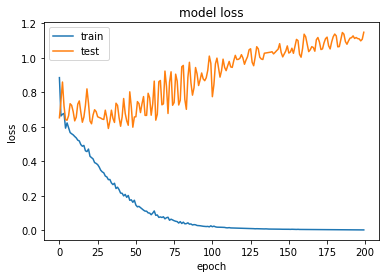

In [29]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model

In [30]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at D:\Projects\ESA\audio-sentiment-analysis\prototypes\saved_models\Emotion_Voice_Detection_Model.h5 


In [31]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [32]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 75.00%


## Predicting emotions on the test data

In [33]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 0s 996us/step


In [34]:
preds

array([[0.9727154 , 0.02728456],
       [0.03410935, 0.9658907 ],
       [0.96284723, 0.03715273],
       [0.00526357, 0.9947364 ],
       [0.37892434, 0.62107563],
       [0.00209961, 0.99790037],
       [0.00294244, 0.99705756],
       [0.9944845 , 0.00551551]], dtype=float32)

In [35]:
preds1=preds.argmax(axis=1)

In [36]:
preds1

array([0, 1, 0, 1, 1, 1, 1, 0], dtype=int64)

In [37]:
abc = preds1.astype(int).flatten()

In [38]:
predictions = (lb.inverse_transform((abc)))

In [39]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf

,predictedvalues
0,Angry
1,Happy
2,Angry
3,Happy
4,Happy
5,Happy
6,Happy
7,Angry


In [40]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [41]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf

,actualvalues
0,Angry
1,Angry
2,Angry
3,Angry
4,Happy
5,Happy
6,Happy
7,Angry


In [42]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [43]:
finaldf[0:4]

,actualvalues,predictedvalues
0,Angry,Angry
1,Angry,Happy
2,Angry,Angry
3,Angry,Happy


In [44]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
Angry,5
Happy,3


In [45]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
Angry,3
Happy,5


In [46]:
finaldf.to_csv('Predictions.csv', index=False)

## Live Demo

## you could find this track on below link:

https://tuenl.sharepoint.com/sites/gad_cbo/JPC/MC/ESA%20PDEng%20ST%20Project/Forms/AllItems.aspx?viewid=235c9f56%2Db4dc%2D418e%2D8800%2Dd0cde58fff30&id=%2Fsites%2Fgad%5Fcbo%2FJPC%2FMC%2FESA%20PDEng%20ST%20Project%2FModelsAndData%2FAudio%2FDevelopment%2Fdata%2Ftone%5Fcnn%5Fhappy%5Fangry%5Fdataset%5Fsample%5Fprediction%5Ftracks

In [47]:
data, sampling_rate = librosa.load(path + '\\data\\output10.wav')

C:\Users\20194998\Anaconda3\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Projects\\ESA\\audio-sentiment-analysis\\data\\tone_cnn_happy_angry_dataset\\\\data\\output10.wav'

In [ ]:
%pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [52]:
X, sample_rate = librosa.load(path +'Recording.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [53]:
livedf2= pd.DataFrame(data=livedf2)

In [54]:
livedf2 = livedf2.stack().to_frame().T

In [55]:
livedf2

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-42.318398,-42.318398,-42.318398,-42.318398,-42.318398,-42.318398,-42.318398,-42.318398,-42.318398,-42.318398,...,-24.143869,-24.293356,-24.797838,-25.788174,-25.055706,-23.645973,-21.937735,-18.940521,-17.401972,-14.991854


In [56]:
twodim= np.expand_dims(livedf2, axis=2)

In [57]:
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 0s 2ms/step


In [58]:
livepreds

array([[0.34671924, 0.6532808 ]], dtype=float32)

In [59]:
livepreds1=livepreds.argmax(axis=1)

In [60]:
liveabc = livepreds1.astype(int).flatten()

In [61]:
livepredictions = (lb.inverse_transform((liveabc)))
livepredictions

array(['Happy'], dtype=object)